In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd
from scipy.stats import chi2
from scipy.special import sph_harm
import healpy as hp
import numpy.ma as ma
# from units import *
# import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load quasars into a DataFrame
quasars_pd = pd.read_csv("../data/quasars_phot.csv")

In [3]:
quasars_pd.columns.values

array(['source_id', 'parallax', 'parallax_error', 'ra', 'dec', 'ra_error',
       'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmra_pmdec_corr', 'astrometric_gof_al',
       'astrometric_matched_observations', 'visibility_periods_used',
       'astrometric_sigma5d_max', 'radial_velocity',
       'radial_velocity_error', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_weight_al',
       'astrometric_chi2_al', 'matched_observations', 'phot_g_mean_mag',
       'phot_bp_rp_excess_factor'], dtype=object)

In [4]:
quasars_pd = quasars_pd#[quasars_pd['phot_g_mean_mag'] < 18] # Select subset

In [5]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values

In [6]:
pm_ra_cosdec = quasars_pd['pmra'].values*np.cos(quasars_pd['dec'].values*np.pi/180.)
pm_dec = quasars_pd['pmdec'].values
radial_velocity = quasars_pd['radial_velocity'].values

In [29]:
# quasars_icrs = SkyCoord(ra=ra*u.deg, 
#              dec=dec*u.deg, 
#              pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, 
#              pm_dec=pm_dec*u.mas/u.yr,
#              radial_velocity=radial_velocity*u.km/u.s,
#              frame='icrs')

quasars_gal = SkyCoord(l=ra*u.deg, 
             b=dec*u.deg, 
             pm_l_cosb=pm_ra_cosdec*u.mas/u.yr, 
             pm_b=pm_dec*u.mas/u.yr,
             radial_velocity=radial_velocity*u.km/u.s,
             frame='galactic')

In [15]:
quasars_gal = quasars_icrs.transform_to('galactic')
quasars_ecl = quasars_icrs.transform_to('barycentrictrueecliptic')

In [28]:
coords_qsrs = SkyCoord(l=ra*u.deg, b=dec*u.deg, frame='galactic')

In [30]:
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value#/np.cos(b_gal*np.pi/180)
pm_b_gal = quasars_gal.pm_b.value

In [31]:
l_gal = quasars_ecl.lon.value #quasars_gal.l.value
b_gal = quasars_ecl.lat.value #quasars_gal.b.value

In [32]:
quasars_icrs.ra.value

array([ 44.91049765,  45.18857524,  45.1894804 , ..., 315.09386025,
       314.9771333 , 315.16372631])

In [33]:
quasars_ecl.lon.value

array([ 42.50461602,  42.80966793,  42.83388021, ..., 317.402508  ,
       317.34338403, 317.52589895])

In [34]:
nside = 32
qpix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))
# qpix = hp.ang2pix(nside,np.deg2rad(l_gal),np.deg2rad(b_gal))

quasars_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))
rv_map = np.zeros(hp.nside2npix(nside))

In [35]:
for idx, ipix in enumerate(tqdm_notebook((qpix))):
    quasars_map[ipix] += 1
    pm_l_map[ipix] += pm_l_gal[idx]
    pm_b_map[ipix] += pm_b_gal[idx]
    rv_map[ipix] += radial_velocity[idx]

# Divide by quasar counts
pm_l_map /= quasars_map
pm_b_map /= quasars_map
rv_map /= quasars_map

pm_l_map = np.nan_to_num(pm_l_map)
pm_b_map = np.nan_to_num(pm_b_map)
rv_map = np.nan_to_num(rv_map)

A Jupyter Widget

/home/sm8383/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/sm8383/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/sm8383/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/sm8383/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/sm8383/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/sm8383/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


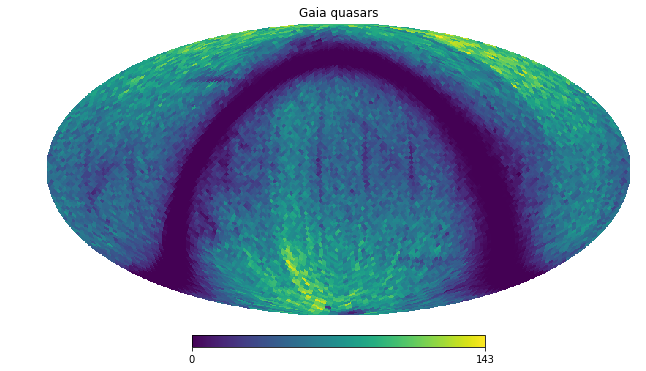

In [36]:
hp.mollview(quasars_map, title="Gaia quasars")

In [28]:
# plt.plot(hp.anafast(quasars_map))
# plt.xscale("log")
# plt.yscale("log")

In [29]:
# hp.mollview(pm_l_map, title="Gaia quasars",min = -10, max = 10)
# hp.mollview(pm_b_map, title="Gaia quasars",min = -10, max = 10)

In [30]:
from healpy.sphtfunc import Alm

def fB(l, m, gtheta_ary, gphi_ary, lmax):
    return 1/np.sqrt(l*(l+1))*(((l*(l-m+1)/(2*l+1))*gtheta_ary[Alm.getidx(lmax, l+1,m)]) - ((l+1)*(l+m)/(2*l+1)*gtheta_ary[Alm.getidx(lmax, l-1,m)] -1.j*m*gphi_ary[Alm.getidx(lmax, l,m)]))
    
def fC(l, m, gtheta_ary, gphi_ary, lmax):
    return 1/np.sqrt(l*(l+1))*(-1.j*m*gtheta_ary[Alm.getidx(lmax, l,m)]-(l*(l-m+1)/(2*l+1))*gphi_ary[Alm.getidx(lmax, l+1,m)] + ((l+1)*(l+m)/(2*l+1)*gphi_ary[Alm.getidx(lmax, l-1,m)]))


In [31]:
pm_l_map_aux = np.zeros(hp.nside2npix(nside))
pm_b_map_aux = np.zeros(hp.nside2npix(nside))
quasar_map_aux = np.zeros(hp.nside2npix(nside))

for idx, ipix in enumerate(tqdm_notebook((qpix))):
    theta, phi = hp.pix2ang(nside, ipix)
    pm_l_map_aux[ipix] += pm_l_gal[idx]/np.sin(theta)
    pm_b_map_aux[ipix] += pm_b_gal[idx]/np.sin(theta)
    quasar_map_aux[ipix] += quasars_map[idx]/np.sin(theta)
    
# pm_l_map_aux /= quasars_map
# pm_b_map_aux /= quasars_map

# pm_l_map_aux = np.nan_to_num(pm_l_map_aux)
# pm_b_map_aux = np.nan_to_num(pm_b_map_aux)

IndexError: index 12288 is out of bounds for axis 0 with size 12288

In [32]:
lmax = 3*nside - 1

alm_theta = hp.map2alm(pm_b_map_aux, lmax=lmax)
alm_phi = hp.map2alm(pm_l_map_aux, lmax=lmax)
Cl_quasars = hp.anafast(quasars_map, lmax=lmax)

In [99]:
fB_ary = np.zeros((lmax, lmax))
fC_ary = np.zeros((lmax, lmax))
for l in tqdm_notebook(range(lmax - 1)):
    for m in range(l):
        fB_ary[l][m] = np.abs(fB(l, m , alm_theta, alm_phi, lmax))**2
        fC_ary[l][m] = np.abs(fC(l, m , alm_theta, alm_phi, lmax))**2

In [100]:
Cl_B = 2*np.sum(fB_ary, axis=1)
Cl_C = 2*np.sum(fC_ary, axis=1)

ell = np.arange(len(Cl_B))

Cl_B /= 2*ell+1
Cl_C /= 2*ell+1

In [101]:
# vtot_map = np.sqrt(pm_b_map**2 + pm_l_map**2)

In [102]:
# white_noise = np.ma.asarray(np.random.normal(np.mean(vtot_map),np.std(vtot_map),  pm_l_map.shape))
# hp.mollview(white_noise)
# alm_wn = hp.map2alm(white_noise)

In [103]:
# wn_alm_ary = np.zeros((lmax, lmax))
# for l in tqdm_notebook(range(lmax - 1)):
#     for m in range(l):
#         wn_alm_ary[l][m] = np.abs(alm_wn[Alm.getidx(lmax,l,m)])**2

In [104]:
# Cl_wn = 2*np.sum(wn_alm_ary, axis=1)
# Cl_wn /= 2*ell+1

In [21]:
# # plt.plot(ell, Cl_wn, label="White noise", color='grey', alpha=0.9, ls='--')
# plt.plot(ell, Cl_B, label="Curl-free", color='cornflowerblue', alpha=0.9)
# plt.plot(ell, Cl_C, label="Div-free", color='firebrick', alpha=0.9)

# plt.xlabel("$\ell$")
# plt.ylabel(r'$C_\ell$ [mas$^2$ yr$^{-2}$]')
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.xlim(20,lmax-100)
# plt.ylim(1e-1,5)
# plt.title("Gaia quasar velocity angular power spectrum")

# Analysis

In [37]:
from healpy.sphtfunc import Alm

def fB(l, m, gtheta_ary, gphi_ary, lmax):
    return 1/np.sqrt(l*(l+1))*(((l*(l-m+1)/(2*l+1))*gtheta_ary[Alm.getidx(lmax, l+1,m)]) - ((l+1)*(l+m)/(2*l+1)*gtheta_ary[Alm.getidx(lmax, l-1,m)] -1.j*m*gphi_ary[Alm.getidx(lmax, l,m)]))
    
def fC(l, m, gtheta_ary, gphi_ary, lmax):
    return 1/np.sqrt(l*(l+1))*(-1.j*m*gtheta_ary[Alm.getidx(lmax, l,m)]-(l*(l-m+1)/(2*l+1))*gphi_ary[Alm.getidx(lmax, l+1,m)] + ((l+1)*(l+m)/(2*l+1)*gphi_ary[Alm.getidx(lmax, l-1,m)]))

In [103]:
np.std(pm_l_gal)

1.191805259471351

In [104]:
np.std(pm_b_gal)

1.0535990016258612

In [17]:
def make_sim_aux_maps():
    nquas = len(quasars_pd) # Total number of quasars

    # Draw proper motions as in data
    pm_l_sim = np.random.normal(0, np.std(pm_l_gal), nquas)
    pm_b_sim = np.random.normal(0, np.std(pm_b_gal), nquas)

    # Plop them down on random healpix pixels
    qpix_sim = np.random.randint(0, hp.nside2npix(nside), nquas)

    pm_l_map_aux = np.zeros(hp.nside2npix(nside))
    pm_b_map_aux = np.zeros(hp.nside2npix(nside))
    quasars_map = np.zeros(hp.nside2npix(nside))

    # Get auxilliary variables map
    for idx, ipix in enumerate(((qpix_sim))):
        theta, phi = hp.pix2ang(nside, ipix)
        quasars_map[ipix] += 1
        pm_l_map_aux[ipix] += pm_l_sim[idx]/np.sin(theta)
        pm_b_map_aux[ipix] += pm_b_sim[idx]/np.sin(theta)

    # Normalize as mean velocity
    quasars_map[quasars_map == 0] = 1.
    pm_l_map_aux /= quasars_map
    pm_b_map_aux /= quasars_map
    return pm_b_map_aux, pm_l_map_aux

In [18]:
def get_alm_2d(map_theta, map_phi):
    nside = hp.npix2nside(len(map_theta))
    lmax = 3*nside - 1

    alm_theta = hp.map2alm(map_theta, lmax=lmax)
    alm_phi = hp.map2alm(map_phi, lmax=lmax)
    return alm_theta, alm_phi, lmax

In [19]:
def get_Cells(alm_theta, alm_phi, lmax):
    fB_ary = np.zeros((lmax, lmax))
    fC_ary = np.zeros((lmax, lmax))
    for l in (range(lmax - 1)):
        for m in range(l):
            fB_ary[l][m] = np.abs(fB(l, m , alm_theta, alm_phi, lmax))**2
            fC_ary[l][m] = np.abs(fC(l, m , alm_theta, alm_phi, lmax))**2

    Cl_B = 2*np.sum(fB_ary, axis=1)
    Cl_C = 2*np.sum(fC_ary, axis=1)

    ell = np.arange(len(Cl_B))

    Cl_B /= 2*ell+1
    Cl_C /= 2*ell+1
    return Cl_B, Cl_C

In [105]:
Cl_B_sim_ary = []
Cl_C_sim_ary = []

nsim = 50
for isim in tqdm_notebook(range(nsim)):
    map_theta, map_phi = make_sim_aux_maps()
    alm_theta, alm_phi, lmax = get_alm_2d(map_theta, map_phi)
    Cl_B, Cl_C = get_Cells(alm_theta, alm_phi, lmax)
    Cl_B_sim_ary.append(Cl_B)
    Cl_C_sim_ary.append(Cl_C)

In [106]:
Cl_B_sim =  np.percentile(Cl_B_sim_ary, [16,84], axis=0)
Cl_C_sim =  np.percentile(Cl_C_sim_ary, [16,84], axis=0)

In [99]:
pm_l_map_aux = np.zeros(hp.nside2npix(nside))
pm_b_map_aux = np.zeros(hp.nside2npix(nside))
quasars_map_norm = np.zeros(hp.nside2npix(nside))

for idx, ipix in enumerate(tqdm_notebook((qpix))):
    theta, phi = hp.pix2ang(nside, ipix)
    quasars_map_norm[ipix] += 1
    pm_l_map_aux[ipix] += pm_l_gal[idx]/np.sin(theta)
    pm_b_map_aux[ipix] += pm_b_gal[idx]/np.sin(theta)
    
quasars_map_norm[quasars_map_norm == 0] = 1
pm_l_map_aux /= quasars_map_norm
pm_b_map_aux /= quasars_map_norm

In [36]:
alm_theta, alm_phi, lmax = get_alm_2d(pm_b_map_aux, pm_l_map_aux)
Cl_B_data, Cl_C_data = get_Cells(alm_theta, alm_phi, lmax)

In [21]:
def bin_cells(cells, lmin, lmax, nbins):
    bin_edges = np.round(np.logspace(np.log10(lmin),np.log10(lmax), nbins + 1))
    cells_binned = [np.mean(cells[np.int(bin_edges[i]):np.int(bin_edges[i+1])]) for i in range(nbins)]
    ells_binned = (bin_edges[1:] + bin_edges[:-1])/2.
    return ells_binned, cells_binned

/home/sm8383/heptools/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sm8383/heptools/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


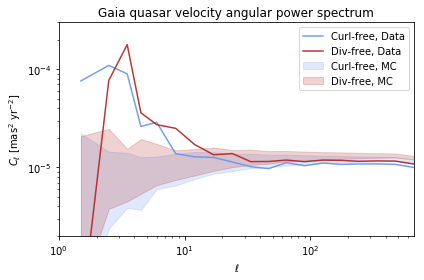

In [108]:
ell = np.arange(len(Cl_C_data))
lmin = 1
nlbins = 20

plt.fill_between(bin_cells(Cl_B_sim[0], lmin, lmax, nlbins)[0], bin_cells(Cl_B_sim[0], lmin, lmax, nlbins)[1], bin_cells(Cl_B_sim[1], lmin, lmax, nlbins)[1], label="Curl-free, MC", color='cornflowerblue', alpha=0.2)
plt.fill_between(bin_cells(Cl_C_sim[0], lmin, lmax, nlbins)[0], bin_cells(Cl_C_sim[0], lmin, lmax, nlbins)[1], bin_cells(Cl_C_sim[1], lmin, lmax, nlbins)[1], label="Div-free, MC", color='firebrick', alpha=0.2)
plt.plot(bin_cells(Cl_B_data, lmin, lmax, nlbins)[0], bin_cells(Cl_B_data, lmin, lmax, nlbins)[1], label="Curl-free, Data", color='cornflowerblue', alpha=0.9)
plt.plot(bin_cells(Cl_C_data, lmin, lmax, nlbins)[0], bin_cells(Cl_C_data, lmin, lmax, nlbins)[1], label="Div-free, Data", color='firebrick', alpha=0.9)

plt.xlabel("$\ell$")
plt.ylabel(r'$C_\ell$ [mas$^2$ yr$^{-2}$]')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(1,lmax-100)
plt.ylim(2e-6,3e-4)
plt.title("Gaia quasar velocity angular power spectrum")
plt.tight_layout()
plt.savefig("QuasarPS_binned.pdf")

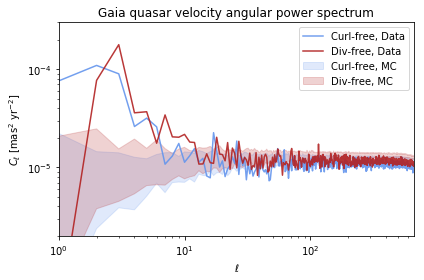

In [109]:
ell = np.arange(len(Cl_C_data))

plt.fill_between(ell, Cl_B_sim[0], Cl_B_sim[1], label="Curl-free, MC", color='cornflowerblue', alpha=0.2)
plt.fill_between(ell, Cl_C_sim[0], Cl_C_sim[1], label="Div-free, MC", color='firebrick', alpha=0.2)
plt.plot(ell, Cl_B_data, label="Curl-free, Data", color='cornflowerblue', alpha=0.9)
plt.plot(ell, Cl_C_data, label="Div-free, Data", color='firebrick', alpha=0.9)

plt.xlabel("$\ell$")
plt.ylabel(r'$C_\ell$ [mas$^2$ yr$^{-2}$]')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(1,lmax-100)
plt.ylim(2e-6,3e-4)
plt.title("Gaia quasar velocity angular power spectrum")
plt.tight_layout()
plt.savefig("QuasarPS.pdf")

# Testing PolSpice

In [33]:
sys.path.append("../heptools/PolSpice_v03-05-01/src/")
from ispice import *
from astropy.io import fits

In [34]:
mask = np.ones_like(quasars_map)
for ipix in range(len(quasars_map)):
    if quasars_map[ipix] == 0:
        mask[ipix] = 0.

In [35]:
! rm quasars.fits
! rm mask.fits

hp.fitsfunc.write_map("quasars.fits", quasars_map)
hp.fitsfunc.write_map("mask.fits", mask)

In [21]:
quasars_map_masked = hp.ma(quasars_map)
quasars_map_masked.mask = np.array(mask, dtype=np.int)

In [ ]:
! rm cl.fits
ispice("quasars.fits", clout="cl.fits", covfileout='cov.fits')
# ispice("quasars.fits", clout="cl_mask.fits", weightfile1="mask.fits")

C_ells = fits.open("cl.fits")[1].data['TT']
ells = np.arange(len(C_ells))
plt.plot(ells, C_ells)

# C_ells = fits.open("cl_mask.fits")[1].data['TT']
# ells = np.arange(len(C_ells))
# plt.plot(ells, C_ells)

plt.plot(hp.anafast(quasars_map))
plt.plot(hp.anafast(quasars_map_masked.filled()))


plt.xlabel("$\ell$")
plt.ylabel(r'$C_\ell$ [mas$^2$ yr$^{-2}$]')
plt.xscale("log")
plt.yscale("log")
# plt.legend()
# plt.xlim(1,lmax-100)
# plt.ylim(2e-6,3e-4)
plt.title("Gaia quasar velocity angular power spectrum")
plt.tight_layout()

rm: cannot remove ‘cl.fits’: No such file or directory
Submitting job 0
../heptools/PolSpice_v03-05-01/src/../build/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile cl.fits -covfileout cov.fits -decouple NO -mapfile quasars.fits -fits_out YES -nlmax -1 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


In [65]:
np.sqrt(hp.nside2pixarea(256, degrees=True))

0.2290324274544937

In [74]:
180/1000

0.18

/home/sm8383/heptools/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sm8383/heptools/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


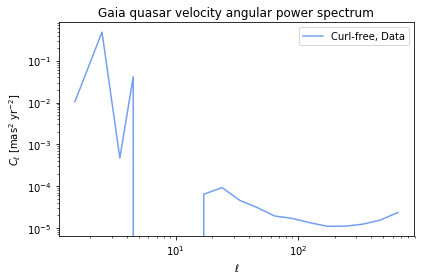

In [63]:
ells = np.arange(len(C_ells))
lmin = 1
nlbins = 20
lmax = 3*nside - 1

plt.plot(bin_cells(C_ells, lmin, lmax, nlbins)[0], bin_cells(C_ells, lmin, lmax, nlbins)[1], label="Curl-free, Data", color='cornflowerblue', alpha=0.9)

plt.xlabel("$\ell$")
plt.ylabel(r'$C_\ell$ [mas$^2$ yr$^{-2}$]')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Gaia quasar velocity angular power spectrum")
plt.tight_layout()

In [187]:
import numpy as np
import time

semivariance=np.random.uniform(0,100,[50300,50300]).astype(np.float64)
prediction=np.random.uniform(0,100,[5030,1]).astype(np.float64)

# start=time.time()
# weights_lstsq = np.linalg.lstsq(semivariance, prediction, rcond=None)
# print("Took: {}".format(time.time()-start))

In [185]:
start=time.time()
weights_pseudo = np.linalg.solve(semivariance.T.dot(semivariance),semivariance.T.dot(prediction))
print("Took: {}".format(time.time()-start))

Took: 3.284543514251709
